# Usage of mongoDB to save the datasets in numpy style

Save the datasets (in this case we'll start with MNIST) in npy style and divide it in many minibatches so they are easier to handle.

These are put into mongoDB

In [3]:
import pymongo
import pickle
import numpy as np

import torchvision
import torch.utils.data as tdata
from torchvision import datasets, transforms

# keras is better to save the dataset
# from keras.datasets import mnist
# from keras.utils import np_utils

import matplotlib.pyplot as plt
import sys

# Ip of minikube and the port of the mongo service
MONGO_IP = '192.168.99.101'
MONGO_PORT = 30933

c:\users\diego\cs\thesis\venv\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\users\diego\cs\thesis\venv\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
c:\users\diego\cs\thesis\venv\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


## Use the pytorch dataset to save the data to mongo

In [3]:
# TODO max document size is 16 MB, this could give us problems in the future
# when the datasets are so big, we should calculate the size (easy, and divide the dataset)
def split_dataset(X, Y, subsets):
    """Splits the X and Y in N different subsets"""
    X_split = np.split(X, subsets)
    Y_split = np.split(Y, subsets)
    
    return X_split, Y_split

def dataset_splits(data, labels, batch_size):
    """ Given the data, return constantly sized
    batches of the dataset, which will be saved to the
    database"""
    for i in range(0, len(data), batch_size):
        yield data[i:i + batch_size], labels[i:i + batch_size]


def approx_size(a: np.array):
    """ approx size of float 32 array in MB"""
    return (32/8) * np.prod(a.shape) / 1e6

In [2]:
train_data = datasets.MNIST('../redisai/data', train=True, download=False)
val_data = datasets.MNIST('../redisai/data', train=False, download=False)

# subsample the datasets 
# train_data.data, train_data.targets = train_data.data[:3000], train_data.targets[:3000]
# val_data.data, val_data.targets = val_data.data[:2000], val_data.targets[:2000]

In [6]:
train_data.data[0].shape

torch.Size([28, 28])

In [3]:
train_data.targets.numpy().shape

(60000,)

In [5]:
# Divide the training data in 100 and the testing data in 10
xtr, ytr = split_dataset(train_data.data, train_data.targets, 100)
xtest, ytest = split_dataset(val_data.data, val_data.targets, 10)

In [6]:
# Make the training data shorter
xtr, ytr = xtr[:10], ytr[:10]
xtest, ytest = xtest[:2], ytest[:2]

In [37]:
np.save('y_train.npy', train_data.targets.numpy()[:5000])

## Download the Keras Dataset and analyze format

In [7]:
((trainX, trainY), (testX, testY)) = mnist.load_data()

NameError: name 'mnist' is not defined

In [ ]:
# the datasets are of size (60000, 28, 28), for pytorch it expects tensors of shape (channels, 28, 28) unlike tensorflow 
# which expects them at the end
trainX = trainX.reshape(trainX.shape[0], 1, 28, 28)
testX = testX.reshape(testX.shape[0], 1, 28, 28)

In [ ]:
# Show a couple of images
f, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(10,5))
ax1.imshow(trainX[0].squeeze()) # Squeeze gets rid of that extra dimension at the beginning
ax2.imshow(trainX[1].squeeze())
print(f'Labels are (ax1)={trainY[0]} (ax2)={trainY[1]}')

In [ ]:
# Normalize the images to the interval [0,1]
trainX = trainX.astype('float32') /255
testX = testX.astype('float32') /255

In [ ]:
# Convert the labels to categorical
trainY = np_utils.to_categorical(trainY)
testY = np_utils.to_categorical(testY)

## Split the dataset in N different subsets

## Test the mongo conn and how to get the db names

In [5]:
client : pymongo.MongoClient = pymongo.MongoClient(MONGO_IP, MONGO_PORT)

In [ ]:
xtr, ytr = split_dataset(trainX, trainY, 100)
xtest, ytest = split_dataset(testX, testY, 10)


In [ ]:
# Make the training data shorter
xtr, ytr = xtr[:10], ytr[:10]
xtest, ytest = xtest[:2], ytest[:2]

In [ ]:
[x.shape for x in ytest]

In [25]:
db['train'].full_name

'mnist.train'

## Get a Connection to Mongo and connect to the database

We'll create a dataset database and one collection will be MNIST

In [6]:
# TODO maybe create a database MNIST and a collection for train and another for test
# that would allow us to skip the train part of it
DB_NAME = 'mnist'
COLLECTION_NAME = 'mnist'

In [13]:
db.train.drop()
db.test.drop()

In [7]:
# Connect to the mongo database and create the mnist collection if we do not have it already
client : pymongo.MongoClient = pymongo.MongoClient(MONGO_IP, MONGO_PORT)
db = client[DB_NAME]


In [ ]:
db.create_collection('train')
db.create_collection('test')
db.list_collection_names()

In [15]:
# Insert the training data
db['train'].insert_many([
    {'_id': i,
     'data': pickle.dumps(data, pickle.HIGHEST_PROTOCOL), 
     'labels':pickle.dumps(labels, pickle.HIGHEST_PROTOCOL)} for i, (data, labels) in enumerate(zip(xtr, ytr))]).inserted_ids

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [16]:
# Insert the test data
# Insert the training data
db['test'].insert_many([
    {'_id': i,
     'data':pickle.dumps(data, pickle.HIGHEST_PROTOCOL), 
     'labels':pickle.dumps(labels, pickle.HIGHEST_PROTOCOL)} for i, (data, labels) in enumerate(zip(xtest, ytest))]).inserted_ids

[0, 1]

In [8]:
# Fetch one of the documents by index
doc = db.test.find_one({"_id": 1})

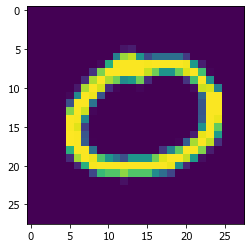

In [10]:
plt.imshow(pickle.loads(doc['data'])[5].squeeze())

In [35]:
# Load the array
arr = pickle.loads(doc['labels'])
arr.shape
arr

array([7, 4, 6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4,
       7, 3, 6, 1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1,
       9, 4, 8, 7, 3, 9, 7, 4, 4, 4, 9, 2, 5, 4, 7, 6, 7, 9, 0, 5],
      dtype=int64)

## Create a dataset from Torch that is able to load the examples from the database

In [ ]:
def split(a, n):
    k, m = divmod(len(a), n)
    return [a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]

split(range(20), 6)

In [ ]:
obj = db.train.find({'_id':{'$gte': 3, '$lte':20}})

In [ ]:
len(np.vstack([xtest[0], xtest[1]]))

In [ ]:
obj = db.test.find({})

In [43]:
DATABASE = 'mnist'

class MnistDataset(tdata.Dataset):
    """ The dataset is able to load a specific subset of samples from MONGO and combine them """

    def __init__(self, func_id, num_func, task, transform=None):
        """ Based on the funcId and the Number of functions, estimate the range of the datasets
        that we should get from mongo.

        :arg func_id ID of the function creating the dataset
        :arg num_func total number of functions invoked
        :arg task either train or val
        :arg transform transformations to be applied
        """

        # create the mongo client
        self.client = pymongo.MongoClient(MONGO_IP, MONGO_PORT)
        self.db = self.client[DATABASE]

        # get the number of documents
        ndocs = self.db.train.count_documents({})

        if task == 'train':
            minibatch = self._split_minibatches(range(ndocs), num_func)[func_id]
            print('I get minibatches', minibatch)

            self.data, self.labels = self._load_data(minibatch)

        # If task is validation we just tell it to load all the data
        else:
            self.data, self.labels = self._load_data()

        self.transforms = transform

    def __len__(self):
        return len(self.data)

    # We could have 1 document per datapoint or group of datapoints?
    # this is just useful for bigger datasets, but could save a lot of memory
    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]

        if self.transforms:
            return self.transforms(x), y
        else:
            return x, y

    # TODO look how we can maybe declare indexes in mongodb to speed this up
    def _load_data(self, minibatches=None):
        """Return the data from the MongoDB already formatted as a numpy array"""

        if minibatches is None:
            # load all because it is the validation
            batches = self.db.test.find({})
        else:
            # Load the objects from Mongo
            batches = self.db.train.find({
                '_id': {'$gte': minibatches.start, '$lte': minibatches.stop-1}
            })

        data, labels = None, None
        for batch in batches:
            # Load the data and the labels and append it to the variables above
            d = pickle.loads(batch['data'])
            l = pickle.loads(batch['labels'])
            
            if data is not None:
                print(data.shape, d.shape)
                print(labels.shape, l.shape)

            if data is None:
                data, labels = d, l
            else:
                data = np.vstack([data, d])
                labels = np.hstack([labels, l])

        return data, labels.flatten()
    
    @staticmethod
    def _split_minibatches(a, n):
        """Based on the number of minibatches return the ones assigned to each
        function so that the count is approximately the same """
        k, m = divmod(len(a), n)
        return [a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]

In [44]:
%%time
d = MnistDataset(func_id=1, num_func=2, task='train')

I get minibatches range(40, 79)
(64, 28, 28) (64, 28, 28)
(64,) (64,)
(128, 28, 28) (64, 28, 28)
(128,) (64,)
(192, 28, 28) (64, 28, 28)
(192,) (64,)
(256, 28, 28) (64, 28, 28)
(256,) (64,)
(320, 28, 28) (64, 28, 28)
(320,) (64,)
(384, 28, 28) (64, 28, 28)
(384,) (64,)
(448, 28, 28) (64, 28, 28)
(448,) (64,)
(512, 28, 28) (64, 28, 28)
(512,) (64,)
(576, 28, 28) (64, 28, 28)
(576,) (64,)
(640, 28, 28) (64, 28, 28)
(640,) (64,)
(704, 28, 28) (64, 28, 28)
(704,) (64,)
(768, 28, 28) (64, 28, 28)
(768,) (64,)
(832, 28, 28) (64, 28, 28)
(832,) (64,)
(896, 28, 28) (64, 28, 28)
(896,) (64,)
(960, 28, 28) (64, 28, 28)
(960,) (64,)
(1024, 28, 28) (64, 28, 28)
(1024,) (64,)
(1088, 28, 28) (64, 28, 28)
(1088,) (64,)
(1152, 28, 28) (64, 28, 28)
(1152,) (64,)
(1216, 28, 28) (64, 28, 28)
(1216,) (64,)
(1280, 28, 28) (64, 28, 28)
(1280,) (64,)
(1344, 28, 28) (64, 28, 28)
(1344,) (64,)
(1408, 28, 28) (64, 28, 28)
(1408,) (64,)
(1472, 28, 28) (64, 28, 28)
(1472,) (64,)
(1536, 28, 28) (64, 28, 28)
(1536,

In [42]:
one = np.ones((50,))
print(one)
two = np.ones((8,))
print(two)
np.hstack((one, two)).shape

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1.]


(58,)

In [ ]:
img, lab = d.__getitem__(0)

In [ ]:
img

## Get the dataset labels from the remote cluster

In [4]:
client : pymongo.MongoClient = pymongo.MongoClient('34.67.18.93', 27017)

In [18]:
client.list_database_names()
db = client['cifar10']


In [19]:
doc = db['train'].find_one({"_id": 1})

In [20]:
arr = pickle.loads(doc['labels'])

In [22]:
arr.flatten().shape

(64,)